In [1]:
from time import time
import numpy as np
import pandas as pd

from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator
from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from MulticoreTSNE import MulticoreTSNE as TSNE
from scipy import stat
import scipy

MACHINE_EPSILON = np.finfo(np.double).eps

In [2]:
def _joint_probabilities(X, degrees_of_freedom):
    dist = pdist(X, "sqeuclidean")
    dist += 1.
    dist **= (-degrees_of_freedom)
    P= np.maximum(dist / ( np.sum(dist)), MACHINE_EPSILON)
    return P


def _kl_divergence(params, P, degrees_of_freedom, n_samples, n_components,
                  skip_num_points=0, compute_error=True):

    X_embedded = params.reshape(n_samples, n_components)
    dist = pdist(X_embedded, "sqeuclidean")
    Dist=dist+ 1.
    dist= Dist**(-degrees_of_freedom)
    Q = np.maximum(dist / (np.sum(dist)), MACHINE_EPSILON)
    dist1=Dist**(-1)
    kl_divergence =np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * dist1)
    for i in range(skip_num_points, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i]),
                        X_embedded[i] - X_embedded)
    grad = grad.ravel()
    c = 2*(degrees_of_freedom + 1.0) 
    grad *= c

    return kl_divergence, grad

def _gradient_descent(objective, p0, it, n_iter,
                     n_iter_check=1, n_iter_without_progress=300,
                     momentum=0.5, learning_rate=7, min_gain=0.01,
                     min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = i = it

    tic = time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
       
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            toc = time()
            duration = toc - tic
            tic = toc

            if verbose >= 2:
                print("[t-SNE] Iteration %d: error = %.7f,"
                     " gradient norm = %.7f"
                     " (%s iterations in %0.3fs)"
                     % (i + 1, error, grad_norm, n_iter_check, duration))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                         "during the last %d episodes. Finished."
                         % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                         % (i + 1, grad_norm))
                break

    return p, error, i

#@ray.remote
class SDD(BaseEstimator):
   
   
    _EXPLORATION_N_ITER = 300
    _N_ITER_CHECK =50
    def _fit(self, X, degrees_of_freedom, skip_num_points=0):
        random_state=None
        n_samples=X.shape[0]
        P = _joint_probabilities(X,degrees_of_freedom)

        random_state = check_random_state(random_state)

        X_embedded = 1e-4 * random_state.randn(
               n_samples, 2).astype(np.float32)

        return self._tsne(P, degrees_of_freedom, n_samples,X_embedded=X_embedded,skip_num_points=skip_num_points)
    def _tsne(self, P, degrees_of_freedom, n_samples, X_embedded, skip_num_points=0):
        """Runs t-SNE."""
        params = X_embedded.ravel()

        opt_args = {
           "it": 0,
           "n_iter_check": 50,
           "min_grad_norm": 1e-7,
           "learning_rate": 7,
           "verbose": 0,
           "kwargs": dict(skip_num_points=skip_num_points),
           "args": [P, degrees_of_freedom, n_samples, 2],
           "n_iter_without_progress": 300,
           "n_iter": 300,
           "momentum": 0.8,
       }
        obj_func = _kl_divergence

        params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                     **opt_args)
        P /= 1
        remaining =2000 - 300
        if it < 300 or remaining > 0:
            opt_args['n_iter'] = 2000
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = 300
            params, kl_divergence, it = _gradient_descent(obj_func, params,
                                                         **opt_args)

        self.n_iter_ = it
        X_embedded = params.reshape(n_samples, 2)
        self.kl_divergence_ = kl_divergence

        return X_embedded

In [3]:
import ray
ray.init(ignore_reinit_error=True)

2022-07-04 09:56:50,912	INFO services.py:1477 -- View the Ray dashboard at http://127.0.0.1:8265


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.9.12', ray_version='3.0.0.dev0', ray_commit='3de4657caedefc9b25f18e92565ddf1bd3bcb74d', address_info={'node_ip_address': '127.0.0.1', 'raylet_ip_address': '127.0.0.1', 'redis_address': None, 'object_store_address': 'tcp://127.0.0.1:64235', 'raylet_socket_name': 'tcp://127.0.0.1:63735', 'webui_url': '127.0.0.1:8265', 'session_dir': 'C:\\Users\\home\\AppData\\Local\\Temp\\ray\\session_2022-07-04_09-56-40_494447_16148', 'metrics_export_port': 64555, 'gcs_address': '127.0.0.1:64984', 'address': '127.0.0.1:64984', 'node_id': '1085cdf4010621d40e9da54d262bdc26ace335d52f42927b17e3d18f'})

In [4]:
@ray.remote(num_cpus=8)
def read_files(x):
    x=pd.read_csv(x,nrows=160000,low_memory=False)
    return x

In [6]:
%%time
df=ray.get(read_files.remote('original947.csv'))

CPU times: total: 688 ms
Wall time: 52.9 s


In [9]:
import random
random.seed(10)
random_num=random.sample(range(len(df)),5000)

In [11]:
random_num[:5]

[149789, 8541, 112430, 126500, 151543]

In [12]:
sample=df.iloc[random_num]

In [13]:
dead=sample[sample['Survive']==0].reset_index().loc[:499,:]
alive=sample[sample['Survive']==1].reset_index().loc[:499,:]
DF=pd.concat([dead,alive],axis=0)

In [14]:
DF.to_csv('1000_records.csv',index=False)

In [ ]:
-------------------------------------------------------------

In [54]:
y=DF[['Survive']]
DF=DF.drop(['Survive'],axis=1)
X=DF.loc[:,'_1_MAR_STAT':].copy()
X.shape

(500, 946)

In [55]:
X.columns=range(X.shape[1])
X

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
246,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
248,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [63]:
%%time

A=scipy.spatial.distance.pdist(X, metric='euclidean')
kendSDD=[]

for k in range(1,15):
    print('loop started:',k)
    embedding = SDD()
    X_SDD = embedding._fit(X,degrees_of_freedom=k)
    B=scipy.spatial.distance.pdist(X_SDD, metric='euclidean')
    kendSDD.append(scipy.stats.kendalltau(A, B))

passed=a
loop started: 1


C:\Users\home\AppData\Local\Temp\ipykernel_17304\3264856897.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\home\AppData\Local\Temp\ipykernel_17304\3264856897.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


loop started: 2
loop started: 3
loop started: 4
loop started: 5
loop started: 6
loop started: 7
loop started: 8
loop started: 9
loop started: 10
loop started: 11
loop started: 12
loop started: 13
loop started: 14
CPU times: total: 9min 47s
Wall time: 9min 50s


In [64]:
kendSDD

[KendalltauResult(correlation=0.7295883026405454, pvalue=0.0),
 KendalltauResult(correlation=0.7008412659904191, pvalue=0.0),
 KendalltauResult(correlation=0.6642725493954318, pvalue=0.0),
 KendalltauResult(correlation=0.6096108254802898, pvalue=0.0),
 KendalltauResult(correlation=0.02989244976700943, pvalue=3.631550764891031e-55),
 KendalltauResult(correlation=0.023205453725692153, pvalue=6.12315275417985e-34),
 KendalltauResult(correlation=0.021226731865725993, pvalue=1.1330218656529924e-28),
 KendalltauResult(correlation=0.02741004663115225, pvalue=1.142410056787915e-46),
 KendalltauResult(correlation=0.002437614724974199, pvalue=0.20204907289793517),
 KendalltauResult(correlation=-0.0009548614654826914, pvalue=0.6172648126479952),
 KendalltauResult(correlation=0.004039809559784384, pvalue=0.034493881793918636),
 KendalltauResult(correlation=-0.018847107313574352, pvalue=5.979883669028317e-23),
 KendalltauResult(correlation=-0.0345845213955572, pvalue=3.189730378805333e-73),
 Kendal

In [65]:
kendSDD.index(max(kendSDD))

0

In [87]:
embedding=SDD()
X_SDD = embedding._fit(X,degrees_of_freedom=(kendSDD.index(max(kendSDD))+1))
#X_SDD = embedding._fit(X,degrees_of_freedom=(4))

C:\Users\home\AppData\Local\Temp\ipykernel_17304\3264856897.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\home\AppData\Local\Temp\ipykernel_17304\3264856897.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


In [88]:
y.shape

(500, 2)

In [89]:
mapping={0:'passed away',1:'survived'}
y['mapped']=y['Survive'].map(mapping)

In [90]:
indexes=DF[['index']].values.flatten()

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

li=['p-'+str(i) for i in indexes]

In [92]:
y

,Survive,mapped
0,0.0,passed away
1,0.0,passed away
2,0.0,passed away
3,0.0,passed away
4,0.0,passed away
...,...,...
245,1.0,survived
246,1.0,survived
247,1.0,survived
248,1.0,survived


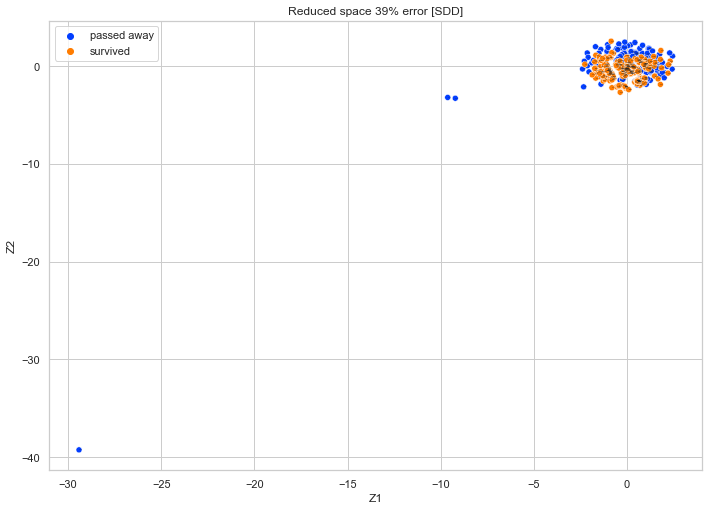

In [93]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')

fig, ax = plt.subplots()
ax=sns.scatterplot(X_SDD[:,0], X_SDD[:,1], hue=np.array(y['mapped']).flatten(), legend='full',palette=palette)
for i, txt in enumerate(li):
    ax.annotate(txt, (X_SDD[i]),fontsize=0.07)
resolution_value = 1080
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Reduced space 39% error [SDD]')
plt.savefig("pic500_60.9confid_SDD_1.png", format="png", dpi=resolution_value)

### tsne

In [94]:
X

,0,1,2,3,4,5,6,7,8,9,...,936,937,938,939,940,941,942,943,944,945
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
246,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
248,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [95]:
A=scipy.spatial.distance.pdist(X, metric='euclidean')
kendTSNE=[]

for k in range(1,500,5):
    embedding = TSNE(n_jobs=8, perplexity=k,n_components=2)
    X_tsne = embedding.fit_transform(X)
    B=scipy.spatial.distance.pdist(X_tsne, metric='euclidean')
    kendTSNE.append(scipy.stats.kendalltau(A, B))

CPU times: total: 1h 18min 42s
Wall time: 13min 28s


In [96]:
kendTSNE

[KendalltauResult(correlation=0.18725543594261398, pvalue=0.0),
 KendalltauResult(correlation=0.20597671266942566, pvalue=0.0),
 KendalltauResult(correlation=0.24511085115745077, pvalue=0.0),
 KendalltauResult(correlation=0.2892615040544596, pvalue=0.0),
 KendalltauResult(correlation=0.2841508818351283, pvalue=0.0),
 KendalltauResult(correlation=0.3146066084700592, pvalue=0.0),
 KendalltauResult(correlation=0.31266616888264437, pvalue=0.0),
 KendalltauResult(correlation=0.3135130064319658, pvalue=0.0),
 KendalltauResult(correlation=0.3463750987286461, pvalue=0.0),
 KendalltauResult(correlation=0.3340427262096364, pvalue=0.0),
 KendalltauResult(correlation=0.3534142773619266, pvalue=0.0),
 KendalltauResult(correlation=0.4138628011838061, pvalue=0.0),
 KendalltauResult(correlation=0.4063928936265193, pvalue=0.0),
 KendalltauResult(correlation=0.4537817119436237, pvalue=0.0),
 KendalltauResult(correlation=0.5014969238545498, pvalue=0.0),
 KendalltauResult(correlation=0.41895370912595764, 

In [ ]:
embedding=TSNE(n_jobs=8,perplexity=(kendTSNE.index(max(kendTSNE))+1),n_components=2)
X_tsne = embedding.fit_transform(X)

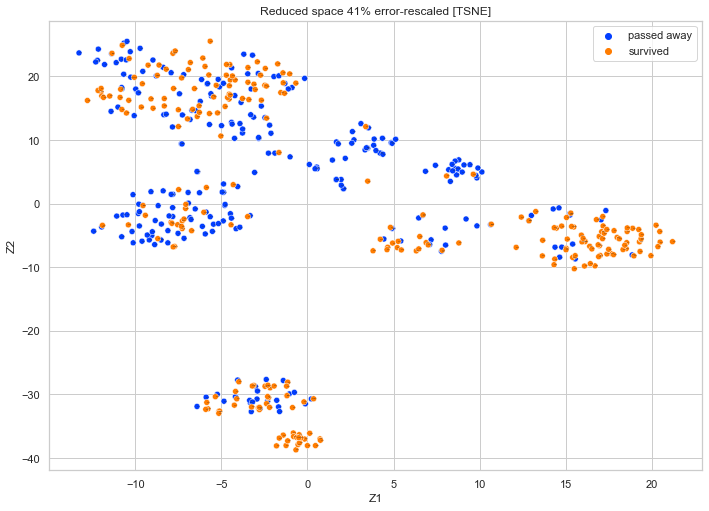

In [101]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 2)
sns.set_style('whitegrid')

fig, ax = plt.subplots()
ax=sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=np.array(y['mapped']).flatten(), legend='full',palette=palette)
for i, txt in enumerate(li):
    ax.annotate(txt, (X_tsne[i]),fontsize=0.07)
resolution_value = 1080
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Reduced space 41% error-rescaled [TSNE]')
plt.savefig("pic500_5_tsne58.8_confid.png", format="png", dpi=resolution_value)

In [30]:
ray.shutdown()

In [ ]:
0.75,0.74,